# Build CNN

In [75]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed

# for working with audio data
import librosa, librosa.display

## Data Preparation

In [2]:
# load metadata csv
df = pd.read_csv('../../Data/features_30_sec.csv')
df = df[['filename', 'label']]

# relative path to the directory of audio file genre subfolders
rel_path = '../../Data/genres_original/'

# create relative path to each audio file
df['file_path'] = rel_path + df['label'] + '/' + df['filename']

# drop 'filename' column
df = df.drop(columns='filename')
df.head()

,label,file_path
0,blues,../../Data/genres_original/blues/blues.00000.wav
1,blues,../../Data/genres_original/blues/blues.00001.wav
2,blues,../../Data/genres_original/blues/blues.00002.wav
3,blues,../../Data/genres_original/blues/blues.00003.wav
4,blues,../../Data/genres_original/blues/blues.00004.wav


In [3]:
# this jazz song is corrupted and will be removed
y, sr = librosa.load(df['file_path'][554])

C:\Users\whitm\Anaconda3\envs\learn-env\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: '../../Data/genres_original/jazz/jazz.00054.wav'

In [4]:
# drop the corrupted song
df = df.drop(labels=554)

# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      999 non-null    object
 1   file_path  999 non-null    object
dtypes: object(2)
memory usage: 23.4+ KB


In [5]:
# instantiate, fit, transform multiclass target
le = LabelEncoder()
y = le.fit_transform(df['label'])

# one hot encode multiclass target
output_shape = df['label'].nunique()
y = keras.utils.to_categorical(y, output_shape)

# check shape
y.shape

(999, 10)

In [6]:
# split into a 10% holdout set
X_t, X_hold, y_t, y_hold = train_test_split(df['file_path'], y, random_state=42, stratify=y, test_size=0.1)

# split into 75% train, 15% test sets
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, random_state=42, stratify=y_t, test_size=15/90)

In [7]:
def get_feature(X, sample_duration):
    features = []
    for sample in X:
        try:
            y, sr = librosa.load(sample, duration=sample_duration)
            S_dB = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr), ref=np.min)
            
            # append to the list and create a new axis for concatenation later and one for the single amplitude channel
            features.append(S_dB[np.newaxis,..., np.newaxis])
        except:
            continue

    # concatenate along the first axis; result should be a 4D tensor of shape (#samples, #mels, #frames, #channels)
    return np.concatenate(features,axis=0)

In [8]:
# generate mel spectrograms for train
X_train_mel = get_feature(X_train, 20)
X_train_mel.shape

(749, 128, 862, 1)

In [9]:
# define input shape
input_shape = X_train_mel.shape[1:]

In [10]:
# generate mel spectrograms for test
X_test_mel = get_feature(X_test, 20)

In [65]:
# custom scaling function
def create_min_max_scaler(X_tr):
    X_tr_max = X_tr.max()
    X_tr_min = X_tr.min()
    def custom_scaler(X):
        return (X - X_tr_min) / (X_tr_max - X_tr_min)
    return custom_scaler

In [62]:
# scale all the spectrograms based on train data
min_max_scaler = create_min_max_scaler(X_train_mel)

# apply the scaling to train and test
X_train_mel_scaled = min_max_scaler(X_train_mel)
X_test_mel_scaled = min_max_scaler(X_test_mel)

In [70]:
# fig, ax = plt.subplots(figsize=(10,6))
# S_dB_img = librosa.display.specshow(X_train_mel_scaled[56, :, :, 0], x_axis='time', y_axis='mel', fmax=8000, ax=ax)
# fig.colorbar(S_dB_img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram', ylabel='Mels');

## First Model - Simple Multi-Layer Perceptron

In [ ]:
# build sequentially
first_model = keras.Sequential

## CNN

In [76]:
input_shape

(128, 862, 1)

In [90]:
batch_size = int(X_train_mel_scaled.shape[0]/50)

In [93]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn = keras.Sequential()

# convolutional and max pooling layers with successively more filters
cnn.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn.add(layers.MaxPooling2D((2, 4)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 4)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 4)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(10, activation='softmax'))

# compile cnn
cnn.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

# take a look at model architecture
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 862, 16)      160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 215, 16)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 215, 32)       4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 53, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 13, 128)      

In [94]:
# fit the model
history = cnn.fit(X_train_mel_scaled,
                  y_train,
                  epochs=16,
                  batch_size=batch_size,
                  validation_data=(X_test_mel_scaled, y_test))

Epoch 1/16
54/54 [==============================] - 21s 389ms/step - loss: 2.3067 - accuracy: 0.1041 - val_loss: 2.2878 - val_accuracy: 0.1200
Epoch 2/16
54/54 [==============================] - 21s 397ms/step - loss: 2.2833 - accuracy: 0.1402 - val_loss: 2.1983 - val_accuracy: 0.2000
Epoch 3/16
54/54 [==============================] - 23s 418ms/step - loss: 2.0005 - accuracy: 0.2550 - val_loss: 1.7689 - val_accuracy: 0.2800
Epoch 4/16
54/54 [==============================] - 21s 380ms/step - loss: 1.7592 - accuracy: 0.3351 - val_loss: 1.6937 - val_accuracy: 0.3467
Epoch 5/16
54/54 [==============================] - 15s 277ms/step - loss: 1.5980 - accuracy: 0.3965 - val_loss: 1.5524 - val_accuracy: 0.4400
Epoch 6/16
54/54 [==============================] - 15s 279ms/step - loss: 1.5153 - accuracy: 0.4232 - val_loss: 1.5561 - val_accuracy: 0.4000
Epoch 7/16
54/54 [==============================] - 15s 285ms/step - loss: 1.4695 - accuracy: 0.4593 - val_loss: 1.4713 - val_accuracy: 0.4400

In [102]:
# Defining a results visualization function
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8), sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

Test loss: 1.3462930917739868
Test accuracy: 0.5066666603088379


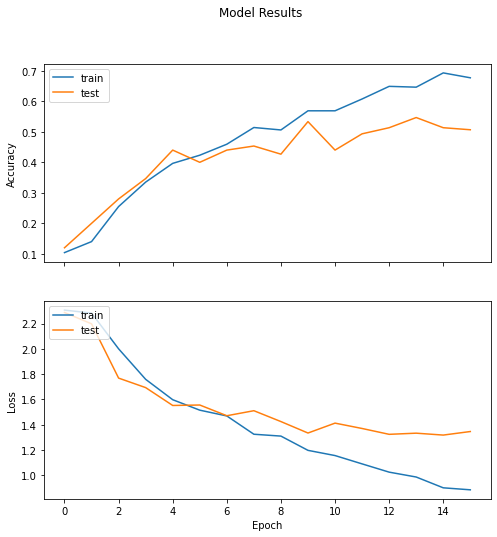

In [103]:
# evaluate
score = cnn.evaluate(X_test_mel_scaled, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)